In [3]:
# Evaluation covered: Dataset completeness & reproducibility (Report + code)
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# Scikit / ML
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc, roc_auc_score,
    precision_recall_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.utils.class_weight import compute_class_weight
import joblib

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

# Colab upload helper (if using Colab)
try:
    from google.colab import files
except:
    pass

print("Libraries loaded.")


Libraries loaded.


In [4]:
import pandas as pd

# Upload manually or via Google Drive
from google.colab import files
uploaded = files.upload()

# Replace the filename with your actual CSV file name
# Try reading with 'latin1' encoding
try:
    df = pd.read_csv("dataset.csv", encoding='latin1')
except UnicodeDecodeError:
    # If 'latin1' fails, try 'ISO-8859-1'
    df = pd.read_csv("dataset.csv", encoding='ISO-8859-1')


# View shape and info
print(df.shape)
print(df.info())
df.head(5)

Saving dataset.csv to dataset.csv
(564, 19)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 564 entries, 0 to 563
Data columns (total 19 columns):
 #   Column                                                                                                Non-Null Count  Dtype 
---  ------                                                                                                --------------  ----- 
 0   ID                                                                                                    564 non-null    object
 1   Timestamp                                                                                             564 non-null    object
 2   Do you agree to allow us to use the data you provide in this Google Form for our academic project  ?  564 non-null    object
 3   Have you ever been diagNosed with diabetes                                                            564 non-null    object
 4     What is your age?                                               

,ID,Timestamp,Do you agree to allow us to use the data you provide in this Google Form for our academic project ?,Have you ever been diagNosed with diabetes,What is your age?,What is your gender?,Have you ever been pregnant?,Did you have diabetes during pregnancy(GDM)?,What is your height (in cm)?,What is your weight (in kg)?,How would you describe your diet?,How often do you exercise per week?,How many hours do you sleep per day?,How often do you smoke (cigarettes or other tobacco products)?,How often do you consume alcohol?,Do you have a family history of diabetes?,Have you ever been diagNosed with high blood pressure?,Have you ever had high cholesterol?,Do you have blurred vision often?
0,ID001,7/19/2025 0:25,Yes,Yes,23,Female,Yes,Yes,153,70,"Moderate (Sometimes healthy, sometimes snacks,...",Rarely,4 - 5 hours,Never,Never,Yes,Yes,Yes,No
1,ID002,7/19/2025 16:58,Yes,Yes,28,Male,Not Related,Not Related,178,62,"Moderate (Sometimes healthy, sometimes snacks,...",Never,6 - 7 hours,Never,I used to drink but quit,No,No,No,No
2,ID003,7/19/2025 19:54,Yes,Yes,32,Female,Yes,No,152,52,"Moderate (Sometimes healthy, sometimes snacks,...",Never,8 - 9 hours,Never,Never,Yes,Yes,Yes,Yes
3,ID004,7/19/2025 23:13,Yes,Yes,27,Male,Not Related,Not Related,159,54,"Moderate (Sometimes healthy, sometimes snacks,...",Never,4 - 5 hours,Never,Never,No,Yes,No,Yes
4,ID005,7/20/2025 20:49,Yes,Yes,60,Female,Yes,No,154,60,"Unhealthy (More white rice, sweets, snacks, oi...",Never,6 - 7 hours,Never,Never,No,No,No,Yes


In [5]:
# Cell 2 - Drop ID/Timestamp, keep rows where Consent == Yes
# (This follows your earlier decisions; cite in report that consenting rows only used.)

# Adjust column renaming if needed (based on your CSV headers)
df = df.rename(columns=lambda s: s.strip())

# Drop ID/Timestamp columns if present
for c in ["ID", "Timestamp", "Time", "TimeStamp"]:
    if c in df.columns:
        df.drop(columns=[c], inplace=True)

# Filter consent column if present (common in your upload)
consent_cols = [c for c in df.columns if 'consent' in c.lower() or 'allow' in c.lower()]
if len(consent_cols) > 0:
    consent_col = consent_cols[0]
    df = df[df[consent_col].astype(str).str.lower().str.strip() == "yes"]
    df.drop(columns=[consent_col], inplace=True)

# Standardize column names to the short names used earlier
col_map = {
    # map your long names to short ones - edit if names in your CSV differ
    "Have you ever been diagNosed with diabetes": "DiagnosedDiabetes",
    "What is your age?": "Age",
    "What is your gender?": "Gender",
    "Have you ever been pregnant?": "Pregnant",
    "Did you have diabetes during pregnancy(GDM)?": "GDM",
    "What is your height (in cm)?": "Height",
    "What is your weight (in kg)?": "Weight",
    "How would you describe your diet?": "Diet",
    "How often do you exercise per week?": "Exercise",
    "How many hours do you sleep per day?": "Sleep",
    "How often do you smoke (cigarettes or other tobacco products)?": "Smoke",
    "How often do you consume alcohol?": "Alcohol",
    "Do you have a family history of diabetes?": "FamilyHistory",
    "Have you ever been diagNosed with high blood pressure?": "HighBP",
    "Have you ever had high cholesterol?": "HighChol",
    "Do you have blurred vision often?": "BlurredVision"
}
# only rename those found
rename_map = {k:v for k,v in col_map.items() if k in df.columns}
df = df.rename(columns=rename_map)



In [6]:
# Cell 3 - Convert messy Age/Height/Weight to numeric, compute BMI, BMI category & AgeGroup
# Evaluation covered: Dataset completeness & preprocessing documentation (show this in report)
import numpy as np
import pandas as pd
import re

def clean_age(x):
    s = str(x)
    s = re.sub(r'\D', '', s)
    return int(s) if s.isdigit() else np.nan

def convert_height(val):
    if pd.isnull(val): return np.nan
    s = str(val).strip().lower()
    s = re.sub(r'[a-zA-Z]', '', s).strip()
    if s == '': return np.nan
    # try float
    try:
        v = float(s)
        # if in meters (e.g., 1.65) but >3 treat as cm already
        if v < 3:  # seems like meters; convert to cm
            return v * 100
        if v > 3 and v < 250:
            return v
        # fallback
        return v
    except:
        return np.nan

def convert_weight(val):
    if pd.isnull(val): return np.nan
    s = str(val).strip().lower()
    s = re.sub(r'[a-zA-Z]', '', s).strip()
    if s == '': return np.nan
    try:
        v = float(s)
        return v if v>10 else np.nan
    except:
        return np.nan

# Apply transforms
if 'Age' in df.columns:
    df['Age'] = df['Age'].apply(clean_age)
if 'Height' in df.columns:
    df['Height'] = df['Height'].apply(convert_height)
if 'Weight' in df.columns:
    df['Weight'] = df['Weight'].apply(convert_weight)

# Filter unrealistic
df = df[(df['Age'].between(18,80)) & (df['Height'].between(40, 250)) & (df['Weight'].between(20,400))]

# BMI, categories
df['Height_m'] = df['Height'] / 100.0
df['BMI'] = df['Weight'] / (df['Height_m']**2)

def bmi_category(b):
    if b < 18.5: return "Underweight"
    if b < 25: return "Normal"
    if b < 30: return "Overweight"
    return "Obese"

df['BMICategory'] = df['BMI'].apply(lambda x: bmi_category(x) if not np.isnan(x) else np.nan)
print("After numeric conversions:", df.shape)
display(df[['Age','Height','Weight','BMI','BMICategory']].head(5))


After numeric conversions: (561, 19)


,Age,Height,Weight,BMI,BMICategory
0,23,153.0,70.0,29.903029,Overweight
1,28,178.0,62.0,19.568236,Normal
2,32,152.0,52.0,22.506925,Normal
3,27,159.0,54.0,21.359915,Normal
4,60,154.0,60.0,25.299376,Overweight


In [7]:
# -----------------------------
# Robust Categorical Encoding
# -----------------------------
import pandas as pd
import numpy as np

# Assume df_cleaned is your DataFrame
# Use the same df variable from Cell 3
df_cleaned = df.copy()

# ---------- 1. Binary mapping ----------
binary_map = {'Yes': 1, 'No': 0}

# Columns using binary mapping
binary_cols = ["DiagnosedDiabetes","FamilyHistory","HighBP","HighChol","BlurredVision"]
for col in binary_cols:
    if col in df_cleaned.columns:
        df_cleaned[col] = df_cleaned[col].map(binary_map).fillna(0).astype(int)

# ---------- 2. Pregnant and GDM ----------
pregnant_map = {'Yes': 1, 'No': 0, 'Not Related': 0}
gdm_map = {'Yes': 1, 'No': 0, 'Not Related': 0}

if 'Pregnant' in df_cleaned.columns:
    df_cleaned['Pregnant'] = df_cleaned['Pregnant'].str.strip().map(pregnant_map).fillna(0).astype(int)

if 'GDM' in df_cleaned.columns:
    df_cleaned['GDM'] = df_cleaned['GDM'].str.strip().map(gdm_map).fillna(0).astype(int)

# ---------- 3. BMI mapping ----------
bmi_map = {"Underweight":0, "Normal":1, "Overweight":2, "Obese":3}
if 'BMICategory' in df_cleaned.columns:
    df_cleaned['BMIvalue'] = df_cleaned['BMICategory'].map(bmi_map).fillna(1).astype(int)

# ---------- 4. Gender mapping ----------
if 'Gender' in df_cleaned.columns:
    gender_map = {'Male':1, 'Female':0}
    df_cleaned['Gender'] = df_cleaned['Gender'].str.strip().map(gender_map).fillna(df_cleaned['Gender'].mode()[0]).astype(int)

# ---------- 5. Diet mapping ----------
diet_map = {
    "Healthy (More vegetables, fruits, green leaves, whole grains, fish or chicken)":0,
    "Moderate (Sometimes healthy, sometimes snacks, sweets, or oily food)":1,
    "Unhealthy (More white rice, sweets, snacks, oily or processed food; less vegetables or fruits)":2
}
if 'Diet' in df_cleaned.columns:
    df_cleaned['Diet'] = df_cleaned['Diet'].map(diet_map).fillna(1).astype(int)

# ---------- 6. Exercise mapping ----------
exercise_map = {"Daily":0, "3 - 5 times":1, "Rarely":2, "Never":3}
if 'Exercise' in df_cleaned.columns:
    df_cleaned['Exercise'] = df_cleaned['Exercise'].map(exercise_map).fillna(2).astype(int)

# ---------- 7. Sleep mapping ----------
sleep_map = {
    "Less than 4 hours":0, "4 - 5 hours":1, "6 - 7 hours":2, "8 - 9 hours":3, "10 hours or more":4
}
if 'Sleep' in df_cleaned.columns:
    df_cleaned['Sleep'] = df_cleaned['Sleep'].map(sleep_map).fillna(2).astype(int)

# ---------- 8. Smoke mapping ----------
smoke_map = {
    "Never":0, "No":0, "I used to smoke but quit":1,
    "Occasionally (less than once a week)":2, "Yes":3, "Regularly":3, "Daily":4
}
if 'Smoke' in df_cleaned.columns:
    df_cleaned['Smoke'] = df_cleaned['Smoke'].str.strip().replace(smoke_map).fillna(0).astype(int)

# ---------- 9. Alcohol mapping ----------
alcohol_map = {
    "Never":0, "No":0, "I used to drink but quit":1, "Rarely (less than once a month)":2,
    "Occasionally":3, "Frequently":4, "Very frequently (3 or more times a week)":5, "Daily":6
}
if 'Alcohol' in df_cleaned.columns:
    df_cleaned['Alcohol'] = df_cleaned['Alcohol'].str.strip().replace(alcohol_map).fillna(0).astype(int)

# ---------- 10. AgeGroup mapping ----------
if 'Age' in df_cleaned.columns:
    bins = [18,25,35,45,55,65,75,100]
    labels = ['18-25','26-35','36-45','46-55','56-65','66-75','76+']
    df_cleaned['AgeGroup'] = pd.cut(df_cleaned['Age'], bins=bins, labels=labels, right=True)
    df_cleaned['AgeGroup'] = pd.factorize(df_cleaned['AgeGroup'].astype(str))[0]

# ---------- 11. Drop unnecessary columns ----------
drop_cols = ['Height','Weight','Height_m','BMI','BMICategory','Age']
df_cleaned = df_cleaned.drop(columns=[c for c in drop_cols if c in df_cleaned.columns])

# ---------- 12. Display result ----------
print("After encoding:", df_cleaned.dtypes)
display(df_cleaned.head(5))

# ---------- 13. Save cleaned file ----------
df_cleaned.to_csv("diabetes_survey_cleaned.csv", index=False)
print("Saved cleaned file: diabetes_survey_cleaned.csv")


After encoding: DiagnosedDiabetes    int64
Gender               int64
Pregnant             int64
GDM                  int64
Diet                 int64
Exercise             int64
Sleep                int64
Smoke                int64
Alcohol              int64
FamilyHistory        int64
HighBP               int64
HighChol             int64
BlurredVision        int64
BMIvalue             int64
AgeGroup             int64
dtype: object


/tmp/ipython-input-3517113423.py:67: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_cleaned['Smoke'] = df_cleaned['Smoke'].str.strip().replace(smoke_map).fillna(0).astype(int)
/tmp/ipython-input-3517113423.py:75: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_cleaned['Alcohol'] = df_cleaned['Alcohol'].str.strip().replace(alcohol_map).fillna(0).astype(int)


,DiagnosedDiabetes,Gender,Pregnant,GDM,Diet,Exercise,Sleep,Smoke,Alcohol,FamilyHistory,HighBP,HighChol,BlurredVision,BMIvalue,AgeGroup
0,1,0,1,1,1,2,1,0,0,1,1,1,0,2,0
1,1,1,0,0,1,3,2,0,1,0,0,0,0,1,1
2,1,0,1,0,1,3,3,0,0,1,1,1,1,1,1
3,1,1,0,0,1,3,1,0,0,0,1,0,1,1,1
4,1,0,1,0,2,3,2,0,0,0,0,0,1,2,2


Saved cleaned file: diabetes_survey_cleaned.csv


Class counts:
 DiagnosedDiabetes
1    284
0    277
Name: count, dtype: int64


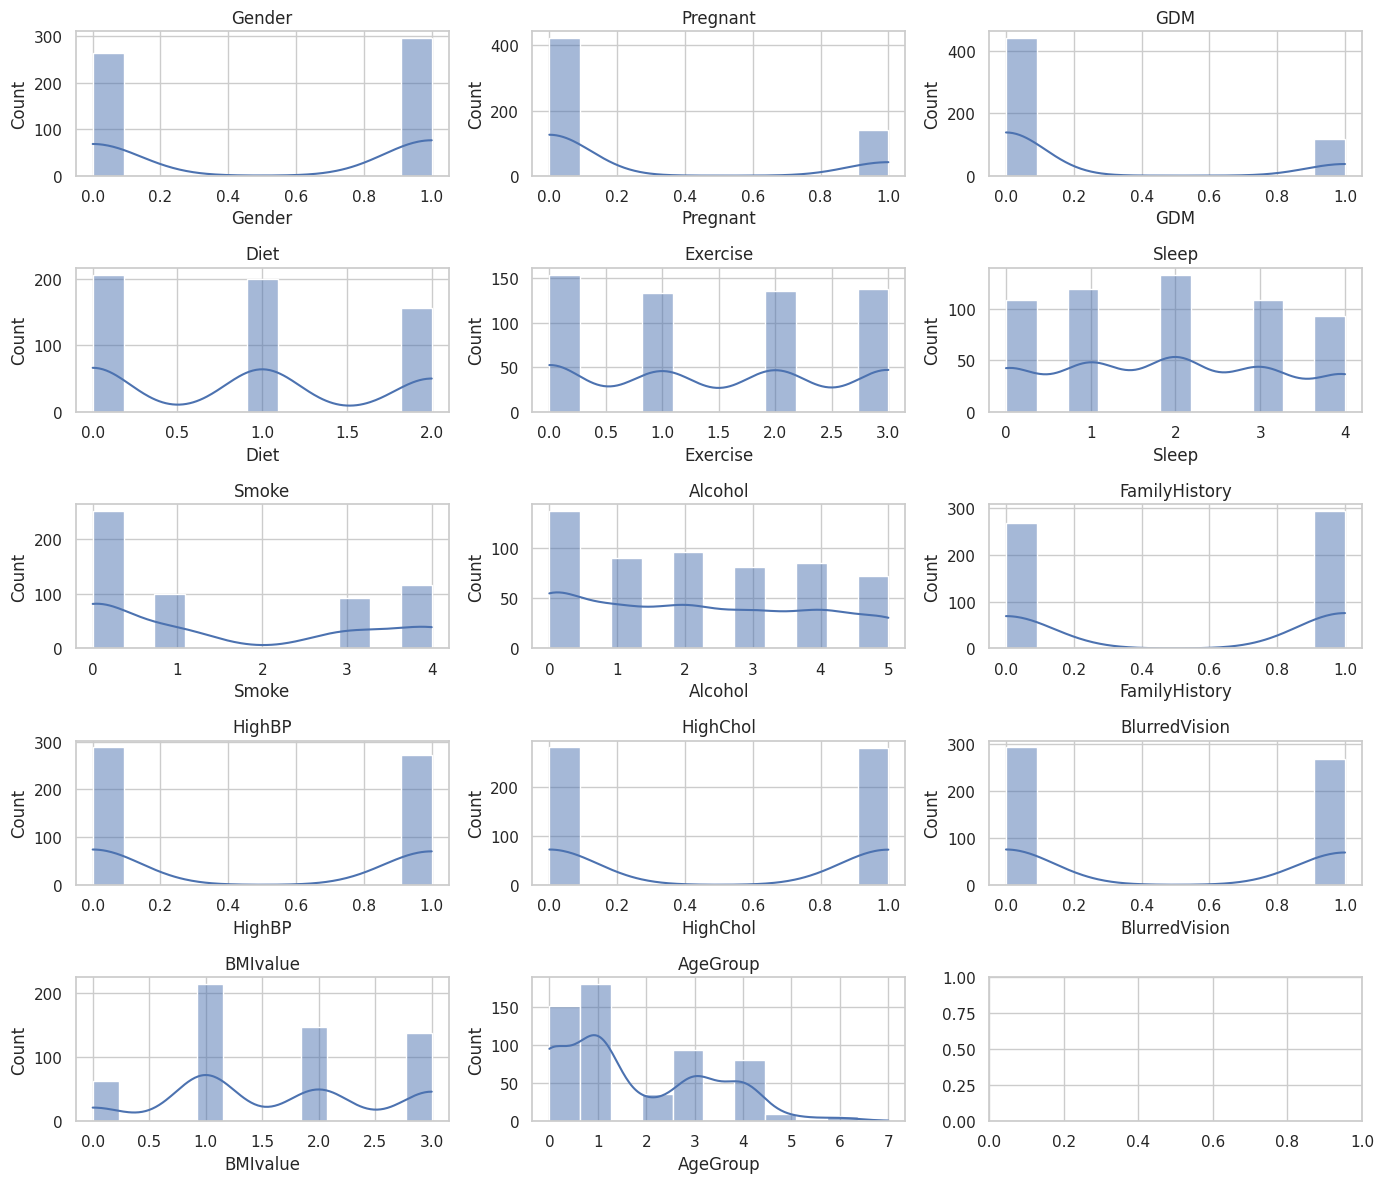

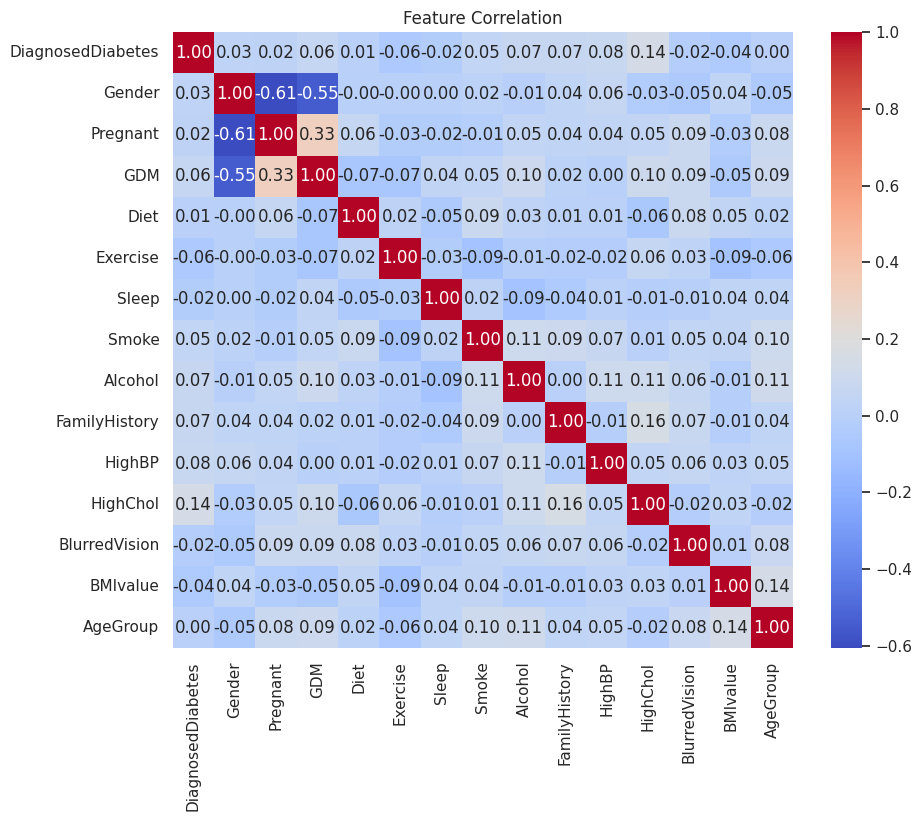

In [8]:
# Cell 5 - EDA: class balance, histograms, correlation and mutual info
# Evaluation covered: Dataset completeness, feature selection (show these plots in presentation)
df = df_cleaned.copy()
# Class balance
print("Class counts:\n", df['DiagnosedDiabetes'].value_counts())

# Histograms for numeric features
num_cols = [c for c in df.columns if df[c].dtype in [np.int64, np.float64] and c != 'DiagnosedDiabetes']
fig, axes = plt.subplots(len(num_cols)//3 + 1, 3, figsize=(14, 12))
axes = axes.flatten()
for i, col in enumerate(num_cols):
    sns.histplot(df[col], ax=axes[i], kde=True)
    axes[i].set_title(col)
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(10,8))
corr = df.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation")
plt.show()



In [9]:
import pandas as pd

# Upload manually or via Google Drive
from google.colab import files
uploaded = files.upload()

# Replace the filename with your actual CSV file name
# Try reading with 'latin1' encoding
try:
    df = pd.read_csv("diabetes_survey_cleaned_600.csv", encoding='latin1')
except UnicodeDecodeError:
    # If 'latin1' fails, try 'ISO-8859-1'
    df = pd.read_csv("diabetes_survey_cleaned_600.csv", encoding='ISO-8859-1')


# View shape and info
print(df.shape)
print(df.info())
df.head(5)

Saving diabetes_survey_cleaned_600.csv to diabetes_survey_cleaned_600.csv
(600, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   DiagnosedDiabetes  600 non-null    int64
 1   Gender             600 non-null    int64
 2   Pregnant           600 non-null    int64
 3   GDM                600 non-null    int64
 4   Diet               600 non-null    int64
 5   Exercise           600 non-null    int64
 6   Sleep              600 non-null    int64
 7   Smoke              600 non-null    int64
 8   Alcohol            600 non-null    int64
 9   FamilyHistory      600 non-null    int64
 10  HighBP             600 non-null    int64
 11  HighChol           600 non-null    int64
 12  BlurredVision      600 non-null    int64
 13  BMIvalue           600 non-null    int64
 14  AgeGroup           600 non-null    int64
dtypes: int64(15)
memory usag

,DiagnosedDiabetes,Gender,Pregnant,GDM,Diet,Exercise,Sleep,Smoke,Alcohol,FamilyHistory,HighBP,HighChol,BlurredVision,BMIvalue,AgeGroup
0,1,0,0,0,1,2,3,2,2,0,0,0,0,2,1
1,1,1,1,1,0,1,2,4,6,0,0,0,0,1,1
2,1,0,0,0,0,0,2,0,2,1,0,0,0,1,0
3,1,0,0,0,1,1,3,0,1,0,0,0,0,2,3
4,1,0,0,0,1,1,3,3,0,1,0,0,1,1,1


Train shape: (480, 14) Test shape: (120, 14)
Class weights: {0: np.float64(1.2060301507537687), 1: np.float64(0.8540925266903915)}
Starting model training...
Epoch 1/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5420 - loss: 0.6988 - val_accuracy: 0.6562 - val_loss: 0.6377
Epoch 2/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6806 - loss: 0.6119 - val_accuracy: 0.6250 - val_loss: 0.6196
Epoch 3/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7069 - loss: 0.5635 - val_accuracy: 0.6875 - val_loss: 0.6139
Epoch 4/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7036 - loss: 0.5599 - val_accuracy: 0.6979 - val_loss: 0.6176
Epoch 5/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7521 - loss: 0.5272 - val_accuracy: 0.6771 - val_loss: 0.6269
Epoch 6/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7054 - loss: 0.5320 - val_accuracy: 0.6771 - val_loss: 0.6325
Epoch 7/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7568 - loss: 0.5006 - 

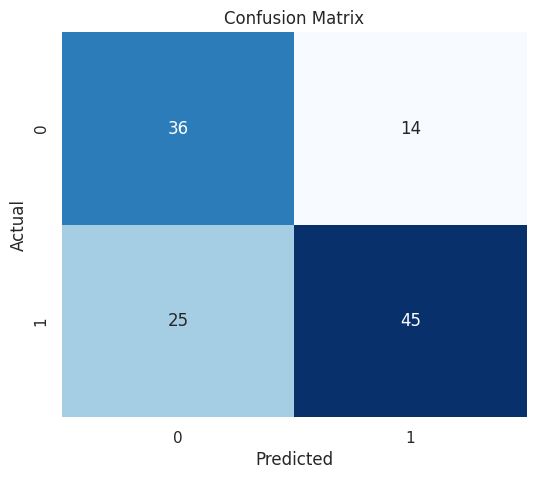

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.72      0.65        50
           1       0.76      0.64      0.70        70

    accuracy                           0.68       120
   macro avg       0.68      0.68      0.67       120
weighted avg       0.69      0.68      0.68       120

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6617 - loss: 0.6122 

Final Model Evaluation:
  - Test Loss: 0.6232
  - Test Accuracy: 67.50%


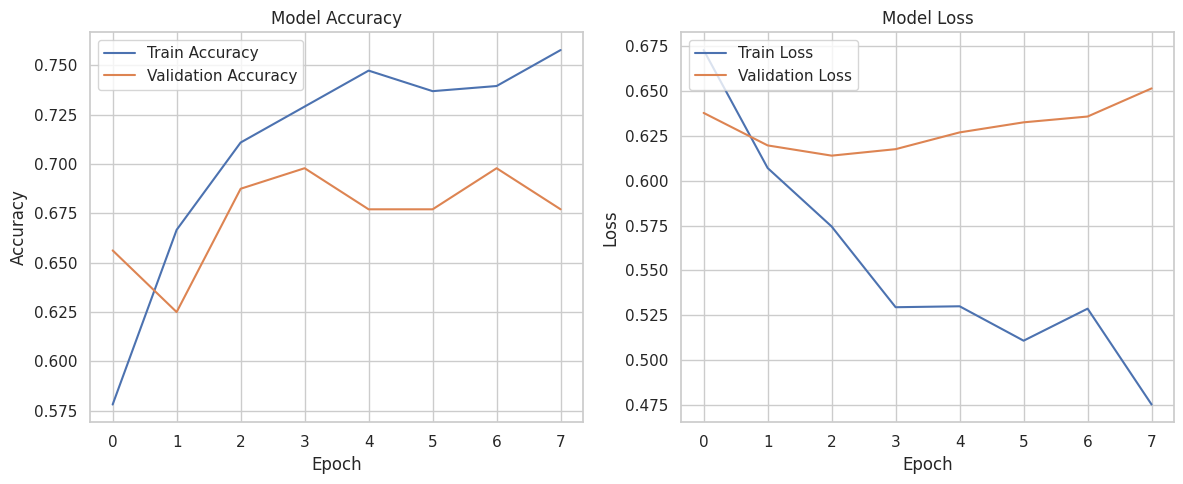

In [10]:
# ---------------------- Corrected Full Neural Network Code ----------------------
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

sns.set(style="whitegrid")

# ---------------------- 1. Load Data ----------------------
df = pd.read_csv("diabetes_survey_cleaned_600.csv")

# Separate features and target
y = df['DiagnosedDiabetes']
X = df.drop(columns=['DiagnosedDiabetes'])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {int(k): v for k, v in zip(np.unique(y_train), class_weights)}
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Class weights:", class_weights_dict)

# ---------------------- 2. Build and Train the Neural Network ----------------------
model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Input layer
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')     # Output layer
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with class weights
print("Starting model training...")
history = model.fit(
    X_train_scaled, y_train,
    epochs=20,
    batch_size=5,
    validation_split=0.2,
    callbacks=[early_stopping],
    class_weight=class_weights_dict,
    verbose=1
)
# ---------------------- 4. Confusion Matrix ----------------------
y_pred_prob = model.predict(X_test_scaled).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Classification Report:\n", classification_report(y_test, y_pred))

# ---------------------- 3. Evaluate the Model ----------------------
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"\nFinal Model Evaluation:\n  - Test Loss: {test_loss:.4f}\n  - Test Accuracy: {test_accuracy * 100:.2f}%")

# ---------------------- 4. Plot Training History ----------------------
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()
